In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations
import numpy as np

from mflex.simulate.simulate_boundary import dalmatian

from mhsflex.field2d import Field2dData, alpha_HS04, check_fluxbalance
from mhsflex.field3d import Field3dData, calculate_magfield
from mhsflex.metrics import compare_field3d

from matplotlib import rc, colors, ticker
import matplotlib.pyplot as plt

from sunpy.net import Fido, attrs as a
import astropy.units as u
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astropy.coordinates import SkyCoord
import sunpy.map
from matplotlib.patches import ConnectionPatch
from matplotlib import colors


rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=True)

c4 = (1.000, 0.224, 0.376)
c1 = (0.439, 0.788, 1.000)
c3 = "black"
c2 = (0.420, 0.502, 1.000)

cmap = colors.LinearSegmentedColormap.from_list(
    "cmap",
    (
        (0.000, (0.000, 0.000, 0.000)),
        (0.500, (0.659, 0.659, 0.659)),
        (1.000, (1.000, 1.000, 1.000)),
    ),
)

cmap2 = colors.LinearSegmentedColormap.from_list(
    "cmap2", ((0.000, (0.984, 1.000, 0.000)), (1.000, (1.000, 0.988, 0.761)))
)

c1 = (0.439, 0.788, 1.000)
c2 = (0.420, 0.502, 1.000)
c3 = "black"
c4 = (1.000, 0.224, 0.376)
c5 = (0.784, 0.231, 0.576)
c7 = (0.992, 0.251, 0.733)
c8 = (0.867, 0.871, 0.184)
c9 = (0.949, 0.922, 0.678)
c10 = (0.984, 0.455, 0.231)
c11 = (0.765, 0.835, 0.922)
c12 = (0.965, 0.694, 0.486)
c13 = (0.992, 0.584, 0.820)

/Users/lilli/Library/Caches/pypoetry/virtualenvs/mflex-cNoQEf_u-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
folder = "/Users/lilli/Desktop/PaperA1/SDO"

In [9]:
path = "/Users/lilli/Desktop/PaperA1/SDO/data/hmi_m_45s_2012_06_13_07_31_30_tai_magnetogram.fits"

hmi_image = sunpy.map.Map(path).rotate()
hdr = hmi_image.fits_header

left_corner = SkyCoord(
    Tx=-450 * u.arcsec, Ty=-220 * u.arcsec, frame=hmi_image.coordinate_frame
)
right_corner = SkyCoord(
    Tx=-250 * u.arcsec, Ty=-100 * u.arcsec, frame=hmi_image.coordinate_frame
)

hpc_coords = sunpy.map.all_coordinates_from_map(hmi_image)
mask = ~sunpy.map.coordinate_is_on_solar_disk(hpc_coords)
magnetogram_big = sunpy.map.Map(hmi_image.data, hmi_image.meta, mask=mask)

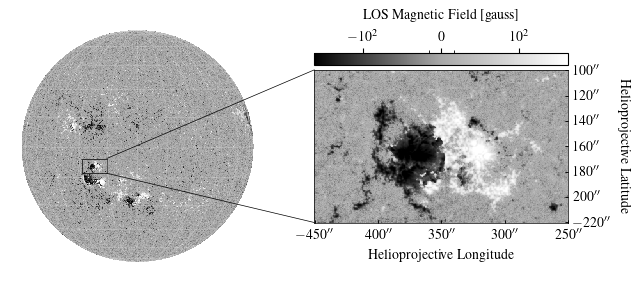

In [10]:
fig = plt.figure(figsize=(7.2, 4.8))
norm = colors.SymLogNorm(50, vmin=-7.5e2, vmax=7.5e2)
ax1 = fig.add_subplot(121, projection=magnetogram_big)
magnetogram_big.plot(
    axes=ax1,
    cmap=cmap,
    norm=norm,
    annotate=False,
)
magnetogram_big.draw_grid(axes=ax1, color="white", alpha=0.25, lw=0.5)
ax1.grid(alpha=0)
for coord in ax1.coords:
    coord.frame.set_linewidth(0)
    coord.set_ticks_visible(False)
    coord.set_ticklabel_visible(False)
    
magnetogram_big.draw_quadrangle(
    left_corner, top_right=right_corner, edgecolor="black", lw=0.5
)
magnetogram_small = hmi_image.submap(left_corner, top_right=right_corner)
ax2 = fig.add_subplot(122, projection=magnetogram_small)
im = magnetogram_small.plot(
    axes=ax2,
    norm=norm,
    cmap=cmap,
    annotate=False,
)
ax2.grid(alpha=0)
lon, lat = ax2.coords[0], ax2.coords[1]
lon.frame.set_linewidth(0.5)
lat.frame.set_linewidth(0.5)
lon.set_axislabel(
    "Helioprojective Longitude",
)
lon.set_ticks_position("b")
lat.set_axislabel(
    "Helioprojective Latitude",
)
lat.set_axislabel_position("r")
lat.set_ticks_position("r")
lat.set_ticklabel_position("r")
xpix, ypix = magnetogram_big.wcs.world_to_pixel(right_corner)
con1 = ConnectionPatch(
    (0, 1),
    (xpix, ypix),
    "axes fraction",
    "data",
    axesA=ax2,
    axesB=ax1,
    arrowstyle="-",
    color="black",
    lw=0.5,
)
xpix, ypix = magnetogram_big.wcs.world_to_pixel(
    SkyCoord(right_corner.Tx, left_corner.Ty, frame=magnetogram_big.coordinate_frame)
)
con2 = ConnectionPatch(
    (0, 0),
    (xpix, ypix),
    "axes fraction",
    "data",
    axesA=ax2,
    axesB=ax1,
    arrowstyle="-",
    color="black",
    lw=0.5,
)
ax2.add_artist(con1)
ax2.add_artist(con2)
ax2.tick_params(direction="in", length=2, width=0.5)

pos = ax2.get_position().get_points()
cax = fig.add_axes([pos[0, 0], pos[1, 1] + 0.01, pos[1, 0] - pos[0, 0], 0.025])
cbar = fig.colorbar(im, cax=cax, orientation="horizontal")
cbar.locator = ticker.FixedLocator([-1e2, 0, 1e2])
cbar.set_label("LOS Magnetic Field [gauss]", labelpad=-40, rotation=0)
cbar.update_ticks()
cbar.ax.xaxis.set_ticks_position("top")
plotname = folder + "/SDO_13062012.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [11]:
data2d = Field2dData.from_fits_SDO(path)

arcsec arcsec 0.504298 0.504298
2.4449034009647783e-06 2.4449034009647783e-06
151961498957.42
151961.49895742
0.3715311856167018 0.3715311856167018


In [12]:
check_fluxbalance(data2d)

-0.1666931474306976

In [13]:
result = Fido.search(
    a.Time("2012/6/13 7:31:00", "2012/6/13 7:32:00"),
    a.Instrument.hmi,
    a.Physobs("intensity"),
)

In [15]:
files = Fido.fetch(result[:, 0], path=folder + "/{file}")

Start Time,End Time,Source,Instrument,Wavelength,Provider,Physobs,Wavetype,Extent Width,Extent Length,Extent Type,Size
,,,,Angstrom,,,,,,,Mibyte
Time,Time,str3,str3,float64[2],str4,str9,str6,str4,str4,str8,float64
2012-06-13 07:31:26.000,2012-06-13 07:31:27.000,SDO,HMI,6173.0 .. 6174.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,-0.00098


In [20]:
x_grid, y_grid = np.meshgrid(data2d.x, data2d.y)
print(data2d.bz.max())
print(data2d.bz.min())

1605.1401408614515
-1422.8482497570396


In [38]:
import matplotlib.patches as mpatches

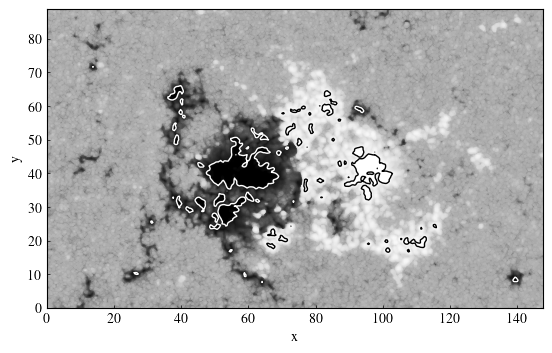

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.grid(color="white", alpha=1.0, linestyle="dotted", linewidth=0.5)
ax.contourf(x_grid, y_grid, data2d.bz, 1000, cmap=cmap, norm = norm)

CS = ax.contour(
    x_grid,
    y_grid,
    data2d.bz,
    levels=np.array((-1500, -500)),
    colors="white",
    linestyles="solid",
    linewidths=1.0,
)
CS2 = ax.contour(
    x_grid,
    y_grid,
    data2d.bz,
    levels=np.array((500, 1700)),
    colors="black",
    linestyles="solid",
    linewidths=1.0,
)

ax.set_box_aspect(data2d.y[-1]/data2d.x[-1])
ax.tick_params(direction="in", length=2, width=0.5)
ax.set_xlabel("x (Mm)")
ax.set_ylabel("y (Mm)")
plotname = folder + "/BC.png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

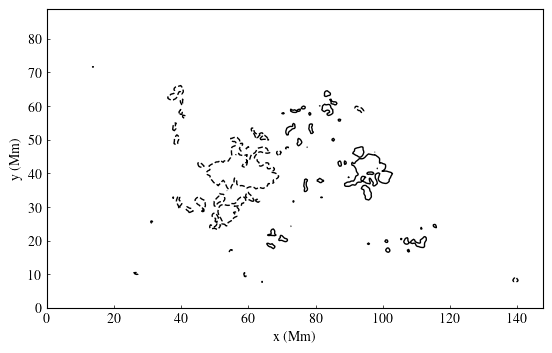

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(
    x_grid,
    y_grid,
    data2d.bz,
    levels=np.array((-500, 500)),
    colors="k",
    linewidths=1.0,
)
# ax.grid(color="black", alpha=1.0, linestyle="dotted", linewidth=0.5)
ax.set_xlabel("x (Mm)")
ax.set_ylabel("y (Mm)")
#ax.clabel(CS, fontsize=14, inline=True)
ax.set_box_aspect(data2d.y[-1]/data2d.x[-1])
ax.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/BC2.png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [53]:
alpha = 0.01

length_scale = float(2.0)  # Normalising length scale for Seehafer

length_scale_x = 2.0 * data2d.nx * data2d.px 
length_scale_y = 2.0 * data2d.ny * data2d.py 

length_scale_x_norm = length_scale_x / length_scale
length_scale_y_norm = length_scale_y / length_scale

kx_arr = np.arange(data2d.nf) * np.pi / length_scale_x_norm  # [0:nf_max]
ky_arr = np.arange(data2d.nf) * np.pi / length_scale_y_norm  # [0:nf_max]
one_arr = 0.0 * np.arange(data2d.nf) + 1.0

ky_grid = np.outer(ky_arr, one_arr)  # [0:nf_max, 0:nf_max]
kx_grid = np.outer(one_arr, kx_arr)  # [0:nf_max, 0:nf_max]

# kx^2 + ky^2

k2_arr = np.outer(ky_arr**2, one_arr) + np.outer(one_arr, kx_arr**2)
k2_arr[0, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2
k2_arr[1, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2
k2_arr[0, 1] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2
# Need k^2 > alpha^2/(1-2a) and k^2 > alpha^2

limit = (k2_arr - (2 * alpha) ** 2) / (2 * k2_arr)

print(limit.min())

0.3827251493497762


In [54]:
alff = 0.0
amhs2 = 0.38
amhs1 = 0.19

In [55]:
b = 1.0
z0 = 2.0
deltaz = 0.2

In [56]:
data3dlff = calculate_magfield(data2d, alff, b, alpha, z0, deltaz)

In [57]:
data3dlff_2F1 = calculate_magfield(data2d, alff, b, alpha, z0, deltaz, asymptotic=False)

In [58]:
data3dmhs1 = calculate_magfield(data2d, amhs1, b, alpha, z0, deltaz)

In [59]:
data3dmhs1_2F1 = calculate_magfield(data2d, amhs1, b, alpha, z0, deltaz, asymptotic=False)

In [60]:
data3dmhs2 = calculate_magfield(data2d, amhs2, b, alpha, z0, deltaz)

In [61]:
data3dmhs2_2F1 = calculate_magfield(data2d, amhs2, b, alpha, z0, deltaz, asymptotic=False)

In [145]:
## where is bz maximal on photosphere  

ix_max = np.unravel_index(data2d.bz.argmax(), data2d.bz.shape)[1]
iy_max = np.unravel_index(data2d.bz.argmax(), data2d.bz.shape)[0]

In [76]:
h1 = 1.0 / 100.0  # Initial step length for fieldline3D
eps = 1.0e-8
# Tolerance to which we require point on field line known for fieldline3D
hmin = 0.0  # Minimum step length for fieldline3D
hmax = 1.0  # Maximum step length for fieldline3D

In [253]:
xmin, xmax, ymin, ymax, zmin, zmax = (
        data3dlff.x[0],
        data3dlff.x[-1],
        data3dlff.y[0],
        data3dlff.y[-1],
        data3dlff.z[0],
        data3dlff.z[-1],
    )

boxedges = np.zeros((2, 3))

# Y boundaries must come first, X second due to switched order explained above

boxedges[0, 0] = 20
boxedges[1, 0] = 70
boxedges[0, 1] = 60
boxedges[1, 1] = 90
boxedges[0, 2] = zmin
boxedges[1, 2] = 2*z0

In [78]:
from msat.pyvis.fieldline3d import fieldline3d

In [104]:
ix_max

262

In [105]:
iy_max

115

In [255]:
70 * (data2d.ny / data2d.y[-1])

188.40948676705975

In [143]:
x_big = np.arange(2.0 * data2d.nx) * 2.0 * xmax / (2.0 * data2d.nx - 1) - xmax
y_big = np.arange(2.0 * data2d.ny) * 2.0 * ymax / (2.0 * data2d.ny - 1) - ymax

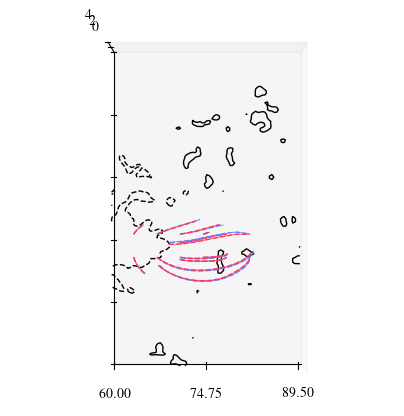

In [276]:
## plot single field line for all 6 solutions from this point

fig = plt.figure()
ax = fig.figure.add_subplot(111, projection="3d")
CS = ax.contour(
    x_grid[53:188, 160:242],
    y_grid[53:188, 160:242],
    data2d.bz[53:188, 160:242],
    levels=np.array((-500, 500)),
    colors="k",
    linewidths=1.0,
    offset=0.0,
)
# ax.grid(color="black", alpha=1.0, linestyle="dotted", linewidth=0.5)
ax.set_xlabel("x (Mm)")
ax.set_ylabel("y (Mm)")
# ax.scatter(data2d.x[ix_max], data2d.y[iy_max], c=c4, s=2.0)
for ix in range(170, data2d.nx-170, 10): 
    for iy in range(100, data2d.ny-120, 10): 
          

        # x_start = (ix_max) / (data2d.nx / data2d.x[-1])
        # y_start = (iy_max) / (data2d.ny / data2d.y[-1])
        # x_start = 63.53183274045601 
        # y_start = 36.78158737605348

        x_start = (ix) / (data2d.nx / data2d.x[-1])
        y_start = (iy) / (data2d.ny / data2d.y[-1])
        ystart = [y_start, x_start, 0.0]

# ax.scatter(x_start, y_start, c=c4)

# if data2d.bz[int(y_start), int(x_start)] < 0.0:
#         h1 = -h1

# # Fieldline3D expects startpt, BField, Row values, Column values so we need to give Y first, then X

# Get fieldline coordinates for reference model

        fieldline_ref = fieldline3d(
            ystart,
            data3dlff.field,
            y_big,
            x_big,
            data3dlff.z,
            h1,
            hmin,
            hmax,
            eps,
            oneway=False,
            boxedge=boxedges,
            gridcoord=False,
            coordsystem="cartesian",
        )

        ax.plot(
            fieldline_ref[:, 1],
            fieldline_ref[:, 0],
            fieldline_ref[:, 2],
            color=c2,
            linewidth=0.5,
            zorder=4000,
        )

        fieldline_ref = fieldline3d(
            ystart,
            data3dlff_2F1.field,
            y_big,
            x_big,
            data3dlff.z,
            h1,
            hmin,
            hmax,
            eps,
            oneway=False,
            boxedge=boxedges,
            gridcoord=False,
            coordsystem="cartesian",
        )

        ax.plot(
            fieldline_ref[:, 1],
            fieldline_ref[:, 0],
            fieldline_ref[:, 2],
            color=c2,
            linewidth=1.0,
            linestyle="dashed",
            zorder=4000,
        )

        # fieldline_ref = fieldline3d(
        #     ystart,
        #     data3dmhs1.field,
        #     y_big,
        #     x_big,
        #     data3dlff.z,
        #     h1,
        #     hmin,
        #     hmax,
        #     eps,
        #     oneway=False,
        #     boxedge=boxedges,
        #     gridcoord=False,
        #     coordsystem="cartesian",
        # )

        # ax.plot(
        #     fieldline_ref[:, 1],
        #     fieldline_ref[:, 0],
        #     fieldline_ref[:, 2],
        #     color=c1,
        #     linewidth=0.5,
        #     zorder=4000,
        # )

        # fieldline_ref = fieldline3d(
        #     ystart,
        #     data3dmhs1_2F1.field,
        #     y_big,
        #     x_big,
        #     data3dlff.z,
        #     h1,
        #     hmin,
        #     hmax,
        #     eps,
        #     oneway=False,
        #     boxedge=boxedges,
        #     gridcoord=False,
        #     coordsystem="cartesian",
        # )

        # ax.plot(
        #     fieldline_ref[:, 1],
        #     fieldline_ref[:, 0],
        #     fieldline_ref[:, 2],
        #     color=c1,
        #     linewidth=1.0,
        #     linestyle="dashed",
        #     zorder=4000,
        # )

        fieldline_ref = fieldline3d(
            ystart,
            data3dmhs2.field,
            y_big,
            x_big,
            data3dlff.z,
            h1,
            hmin,
            hmax,
            eps,
            oneway=False,
            boxedge=boxedges,
            gridcoord=False,
            coordsystem="cartesian",
        )

        ax.plot(
            fieldline_ref[:, 1],
            fieldline_ref[:, 0],
            fieldline_ref[:, 2],
            color=c4,
            linewidth=0.5,
            zorder=4000,
        )

        fieldline_ref = fieldline3d(
            ystart,
            data3dmhs2_2F1.field,
            y_big,
            x_big,
            data3dlff.z,
            h1,
            hmin,
            hmax,
            eps,
            oneway=False,
            boxedge=boxedges,
            gridcoord=False,
            coordsystem="cartesian",
        )

        ax.plot(
            fieldline_ref[:, 1],
            fieldline_ref[:, 0],
            fieldline_ref[:, 2],
            color=c4,
            linewidth=1.0,
            linestyle="dashed",
            zorder=4000,
        )

ax.grid(False)
ax.set_zlim(zmin, 2*z0)  # type: ignore
ax.set_xlim(60, 90)
ax.set_ylim(20, 70)
ax.set_box_aspect((90-60, 70-20, 10*z0))
ax.view_init(90, -90)  # type: ignore

ax.set_yticklabels([])  # type: ignore
ax.set_ylabel("")  # type: ignore

ax.set_zlabel("z (Mm)", labelpad=20 )
ax.set_xlabel("x (Mm)", labelpad=20 )

[t.set_va("center") for t in ax.get_yticklabels()]  # type: ignore
[t.set_ha("center") for t in ax.get_yticklabels()]  # type: ignore

[t.set_va("center") for t in ax.get_zticklabels()]  # type: ignore
[t.set_ha("right") for t in ax.get_zticklabels()]  # type: ignore

[t.set_va("top") for t in ax.get_xticklabels()]  # type: ignore
[t.set_ha("center") for t in ax.get_xticklabels()]  # type: ignore

ax.set_xticks(np.arange(60, 90 + 1.0 , xmax / 10))
ax.set_zticks(np.arange(0, 2*z0 + 1.0 , zmax / 10))  # type: ignore

fig.set_size_inches((5, 5))
# plotname = folder + "/fieldline_comp.png"
# plt.savefig(plotname, dpi=300, bbox_inches="tight")
plt.show()

In [269]:
dpmhs_max = np.zeros_like(data3dmhs2.z)
dpmhs_min = np.zeros_like(data3dmhs2.z)

ddmhs_max = np.zeros_like(data3dmhs2.z)
ddmhs_min = np.zeros_like(data3dmhs2.z)

dpmhs_maxF = np.zeros_like(data3dmhs2.z)
dpmhs_minF = np.zeros_like(data3dmhs2.z)

ddmhs_maxF = np.zeros_like(data3dmhs2.z)
ddmhs_minF = np.zeros_like(data3dmhs2.z)

for iz in range(data3dmhs2.nz):
    dpmhs_max[iz] = data3dmhs2.dpressure[:, :, iz].max()
    dpmhs_min[iz] = data3dmhs2.dpressure[:, :, iz].min()
    ddmhs_max[iz] = data3dmhs2.ddensity[:, :, iz].max()
    ddmhs_min[iz] = data3dmhs2.ddensity[:, :, iz].min()

    dpmhs_maxF[iz] = data3dmhs2_2F1.dpressure[:, :, iz].max()
    dpmhs_minF[iz] = data3dmhs2_2F1.dpressure[:, :, iz].min()
    ddmhs_maxF[iz] = data3dmhs2_2F1.ddensity[:, :, iz].max()
    ddmhs_minF[iz] = data3dmhs2_2F1.ddensity[:, :, iz].min()